## King County Real Estate

### Modeling Home Price Value

Project by: Mahum Abid, Kevin Atkinson, Luke Sims

## Overview

This project will analyze King County housing sales data to create a housing price model.

We have narrowed down the features that most strongly impact housing price to:
- Zip Code
- Grade
- View
- Condition

## Business Problem

Seattle and King County represent one of the most stable and lucrative parts of the American Real Estate Market. Our client, a major real estate investment firm in the area, contracted us to thoroughly examine the factors around housing and land prices to understand better when and what to buy and sell. We came to the following conclusions: 

- SQ Footage of Living Space and Lot Space played a determinant role in the price
- There are specific neighborhoods that retain their value better, especially properties with views, and quality construction and are situated by the waterfront.
- Converting SQ Footage of Basement Space multiply the value per foot by a factor of 4. 
- Garages with Patio spaces atop are a highly preferable modification. 
- Avoid neighborhoods with Private Sewer Systems and older buildings. 

## Data Preparation

In [1]:
import folium as fl
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import statsmodels.api as sm
import json
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

In [2]:
# Loading in data files: raw housing data and school district information
housing_data = 'data/kc_house_data.csv'
school_districts = 'data/school_districts.geojson'
districts_shp = 'data/school_districts.shp'

data = pd.read_csv(housing_data)

#### Let's explore the data to get a feel for what's here:

In [3]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

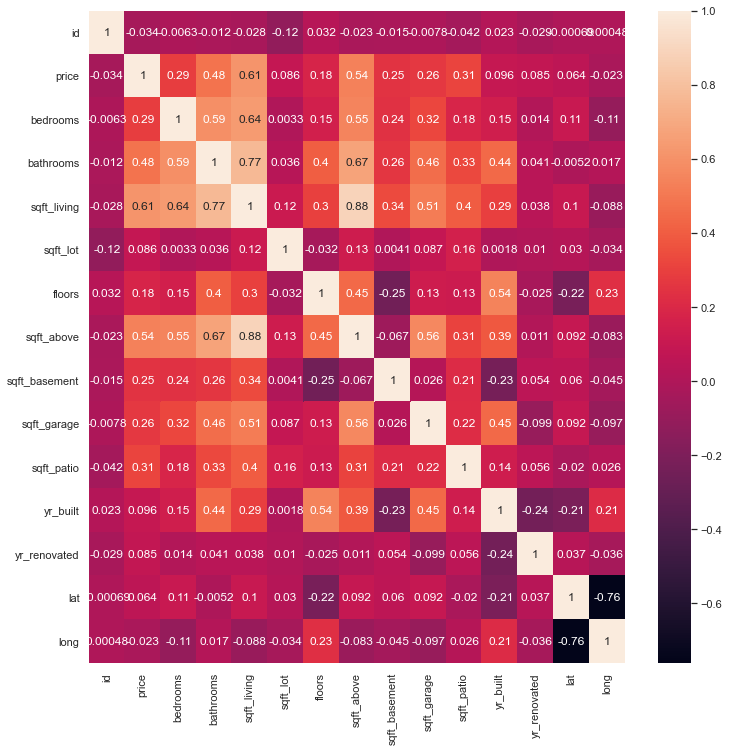

In [5]:
sns.set(rc={'figure.figsize': (12,12)})
sns.heatmap(data.corr(), annot=True);

### Simple Linear Regression

Based on our heatmap above, we can see that price is most strongly correlated with `sqft_living`. Using this information we can create a simple linear regression using `sqft_living` as the independent variable, and `price` as the dependent variable.

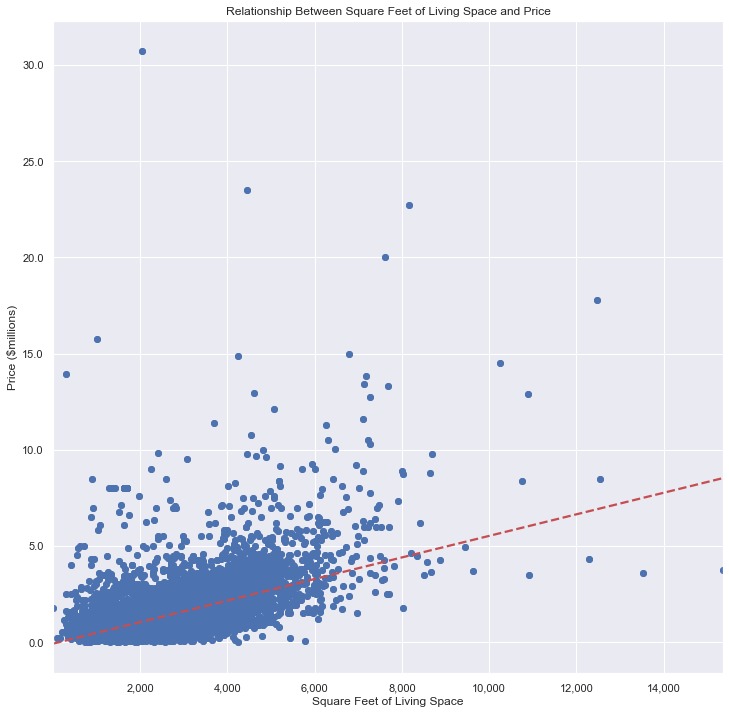

In [6]:
# create plot of square feet of living space vs price with regression
fig, ax = plt.subplots()
plt.scatter(x=data["sqft_living"], y=data["price"])
sns.regplot(data = data, x = 'sqft_living', y = 'price', line_kws={'ls':'--', 'color': 'r'}, ci = None)
ax.set_xlabel('Square Feet of Living Space')
ax.set_ylabel('Price ($millions)')
ax.set_title('Relationship Between Square Feet of Living Space and Price')
ax.set_xticks([(i+1)*2000 for i in range(7)])
ax.set_xticklabels(['2,000', '4,000', '6,000', '8,000', '10,000', '12,000', '14,000'])
ax.set_yticks([i*5000000 for i in range(7)])
ax.set_yticklabels([i*5.0 for i in range(7)]);

### Diving Deeper

Incorporating more features will enable us to gain a more holisitic representaion of each home than is possible using `sqft_living` alone. An extremely valuable aspect of purchasing a home is the school district in which it resides. By utilizing [GIS data](https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::school-districts-in-king-county-schdst-area/explore?location=47.526470%2C-121.923521%2C11.00) for King County School Districts we can isolate which school district each home belongs to. We can then incorporate that information into our model.

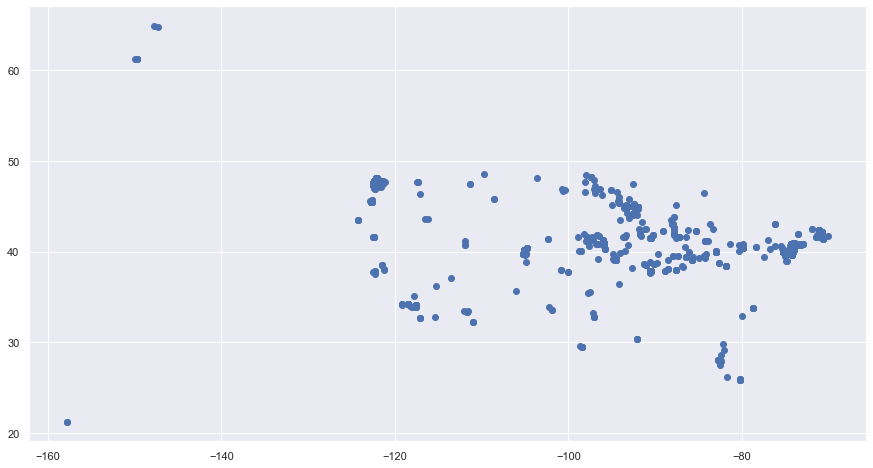

In [7]:
fig, ax = plt.subplots(figsize=[15,8])
ax.scatter(data['long'], data['lat']);

## Cleaning Data for further modeling

### Cleaning Data based on location

As evidenced by the plot above, due to errors in the data set, many of the data points have locations outside of King County. We'll narrow that down to King County in the following cells.

In [8]:
data = data.loc[(data['long'] > -140) & (data['long'] < -121.6) & (data['lat'] > 47.1) & (data['lat'] < 47.8)]

In [9]:
to_drop = data.loc[((data['long'] < -121.9) & (data['lat'] > 47.78)) |
                   ((data['long'] < -122.2) & (data['lat'] < 47.2)) |
                   ((data['long'] > -121.8) & (data['lat'] < 47.2))
                  ]

In [10]:
data = data.drop(index=to_drop.index)

### Removing Outliers

Because our anaylsis is focusing on modeling the most houses as accurately as possible, we'll drop outliers from the `price` and `sqft_lot` columns, as their standard deviations are excessively high.

In [11]:
bottom_025_price = sorted(data['price'])[int(len(data)*0.025)]
top_975_price = sorted(data['price'])[int(len(data)*0.975)]

In [12]:
bottom_025_lot = sorted(data['sqft_lot'])[int(len(data)*0.05)]
top_975_lot = sorted(data['sqft_lot'])[int(len(data)*0.95)]

In [13]:
data = data.loc[(data['price'] > bottom_025_price) & (data['price'] < top_975_price)]

In [14]:
data = data.loc[(data['sqft_lot'] > bottom_025_lot) & (data['sqft_lot'] < top_975_lot)]

### Extracting Zipcode

For our analysis, we're only interested in the Zip Code of the location, so we'll extract Zip Code and drop all address other info

In [15]:
data['zipcode'] = data.address.str.split(',', expand = True)[2].str.strip().str.split(' ', expand = True)[1]
# Because of some oddly formatted addresses, we need to manually assign the zipcode for four rows:
warnings.filterwarnings('ignore')
data['zipcode'].loc[(data['id'] == 139000091) | (data['id'] == 139000123) | (data['id'] == 139000125)] = 98126
data['zipcode'].loc[data['id'] == 4083306403] = 98103
data.drop(['address'], axis=1, inplace=True)
data['zipcode'] = data['zipcode'].astype(int)

In [16]:
# Converting date column into Datetime format, and extracting year
data['date'] = pd.DatetimeIndex(data['date']).year

### Cross-referencing House Location and School Districts

In [17]:
# Creating a simple function to plot each house on the school district map
def plotPoint(df):
    fl.CircleMarker(location=[df['lat'], df['long']], radius=0.1, color='red').add_to(m)

In [18]:
# m = fl.Map(location=[47.51, -122.0],
#            zoom_start=10,
#            control_scale=True,
#            tiles='Stamen Terrain',
#            attr="http://stamen.com")
# fl.GeoJson(school_districts, tooltip=fl.GeoJsonTooltip(fields=['NAME'])).add_to(m)
# data.apply(plotPoint, axis=1)
# m.save("district_map.html")
# m

### Determining School District based on Latitude and Longitude

In order to map a school district to each home, we can use GeoPandas and determine to which region each point belongs.

In [19]:
district_regions = json.load(open(school_districts))

In [20]:
# Create a dictionary with District ID as keys and District Name as values
district_nums = {}
for i in district_regions['features']:
    district_nums[float(i['properties']['OBJECTID']-1)] = i['properties']['NAME']

In [21]:
# Importing school districts shape file and assigning it to variable called district_regions
district_regions = gpd.GeoDataFrame.from_file(districts_shp)

In [22]:
# Creating a new column called 'coords' to be used in a GeoPandas spatial join
data['coords'] = list(zip(data['long'], data['lat']))
data['coords'] = data['coords'].apply(Point)

In [23]:
# Creating a GeoDataFrame called houses, with values of Point Data Type representing the location of each home
houses = pd.DataFrame()
houses = gpd.GeoDataFrame(data['coords'], geometry='coords', crs=district_regions.crs)

In [24]:
# GeoPandas Spatial Join using Home location and School District Regions
house_in_districts = gpd.tools.sjoin(houses, district_regions, predicate="within", how='left')

In [25]:
# Merging our new GeoDataFrame into our DataFrame, and dropping extraneous information
house_in_districts = pd.DataFrame(house_in_districts)
data = data.join(house_in_districts, lsuffix='_left', rsuffix='_right')
data = data.drop(columns=['coords_left', 'coords_right'])
data = data.rename(columns={'index_right':'district'})
data = data.replace({"district": district_nums})
data = data.dropna()

In [26]:
# Saving our cleaned data to a new CSV file
data.to_csv('data/kc_house_data_clean.csv')

## Modeling our Data

In [27]:
# Creating a new DataFrame to be used in our modeling process
# Dropping columns which have proven to not influence the strength of our model
model_data = data.drop(columns=['floors', 'sqft_basement', 'greenbelt', 'nuisance', 'lat', 'long', 'id', 'yr_built'])

## Let's explore which variables should be transformed to be more normal

### Log of price makes for much more normal distribution

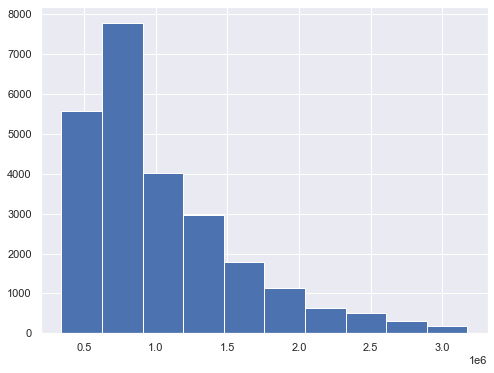

In [28]:
sns.set(rc={'figure.figsize': (8,6)})
model_data['price'].hist();

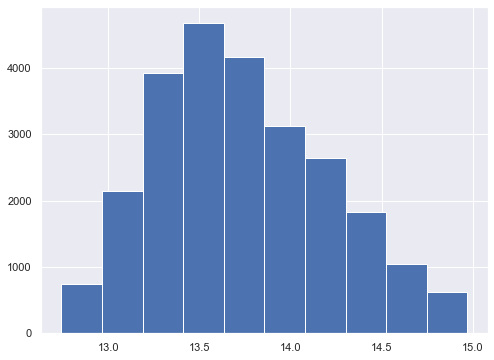

In [29]:
np.log(model_data['price']).hist();

In [30]:
# Saving transformed price column to y variable to be used in modeling
y = np.log(model_data['price'])

### Transforming `sqft_lot` with log makes it much more normally distributed

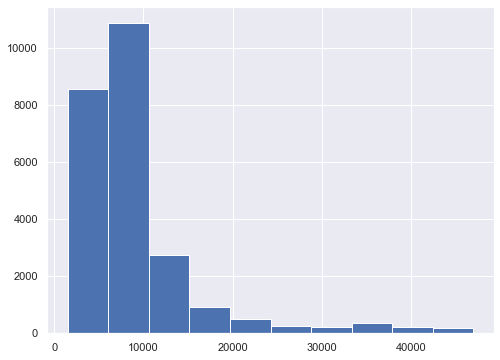

In [31]:
model_data['sqft_lot'].hist();

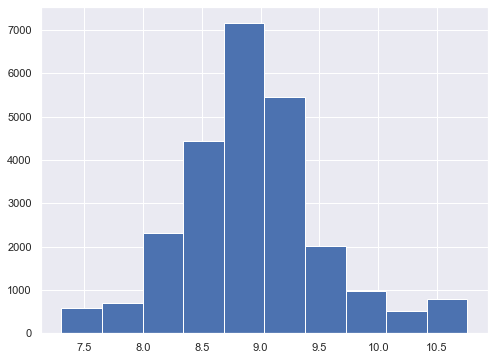

In [32]:
np.log(model_data['sqft_lot']).hist();

In [33]:
model_data['sqft_lot'] = np.log(model_data['sqft_lot'])

### Dummie out district column 
#### $R^2_{adj}$: 0.737

In [34]:
model_data = model_data.join(pd.get_dummies(data['district'])).drop(columns=['district', 'Enumclaw'])

In [35]:
X = sm.add_constant(model_data.drop(columns=['price', 'waterfront', 'view', 'condition', 'grade', 'heat_source', 'sewer_system']))
model = sm.OLS(y, X)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     2500.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:03:07   Log-Likelihood:                -119.06
No. Observations:               24933   AIC:                             296.1
Df Residuals:                   24904   BIC:                             531.7
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -260.0145      8.601    -30.232      0.000    -276.872    -243.157
date                  0.1381      0.003     42.926      0.000       0.132       0.144
bedrooms             -0.0247      0.002    -11.236      0.000      -0.029      -0.020
bathrooms             0.0537      0.003     17.405      0.000       0.048       0.060
sqft_living           0.0002   4.68e-06     44.038      0.000       0.000       0.000
sqft_lot              0.0297      0.003      9.642      0.000       0.024       0.036
sqft_above          8.96e-05   4.17e-06     21.500      0.000    8.14e-05    9.78e-05
sqft_garage         5.73e-05   7.74e-06      7.404      0.000    4.21e-05    7.25e-05
sqft_patio         9.011e-05   7.78e-06     11.582      0.000    7.49e-05       0.000
yr_renovated       3.202e-05   3.74e-06      8.569      0.000    2.47e-05    3.93e-05
zipcode           -7.001e-05   5.79e-05     -1.210      0.226      -0.000    4.34e-05
Auburn               -0.0064      0.013     -0.482      0.630      -0.032       0.019
Bellevue              0.8709      0.013     68.465      0.000       0.846       0.896
Federal Way           0.0196      0.012      1.626      0.104      -0.004       0.043
Fife                  0.0041      0.027      0.150      0.881      -0.049       0.057
Highline              0.1953      0.015     12.920      0.000       0.166       0.225
Issaquah              0.6237      0.013     49.837      0.000       0.599       0.648
Kent                  0.0855      0.012      7.275      0.000       0.062       0.109
Lake Washington       0.7635      0.012     64.939      0.000       0.740       0.787
Mercer Island         0.9613      0.018     52.082      0.000       0.925       0.997
Northshore            0.5394      0.013     41.507      0.000       0.514       0.565
Renton                0.2720      0.013     21.549      0.000       0.247       0.297
Riverview             0.3226      0.017     19.313      0.000       0.290       0.355
Seattle               0.6364      0.013     49.759      0.000       0.611       0.661
Shoreline             0.4709      0.015     30.910      0.000       0.441       0.501
Snoqualmie Valley     0.3994      0.014     29.147      0.000       0.373       0.426
Tahoma                0.1736      0.014     12.838      0.000       0.147       0.200
Tukwila               0.1406      0.025      5.522      0.000       0.091       0.191
Vashon Island         0.3731      0.027     13.634      0.000       0.320       0.427
==============================================================================
Omnibus:                     1808.390   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9186.574
Skew:                          -0.130   Prob(JB):                         0.00
Kurtosis:      

### Dummie out additional object columns

#### Dummie heat source

In [36]:
model_data = model_data.join(pd.get_dummies(model_data['heat_source'], prefix='heat')).drop(columns=['heat_source', 'heat_Gas'])

In [37]:
X = model_data.drop(columns=['price', 'waterfront', 'view', 'condition', 'grade', 'sewer_system'])
model = sm.OLS(y, sm.add_constant(X))
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     2077.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:03:07   Log-Likelihood:                -34.167
No. Observations:               24933   AIC:                             138.3
Df Residuals:                   24898   BIC:                             422.7
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -260.1095      8.577    -30.327      0.000    -276.921    -243.298
date                       0.1381      0.003     43.041      0.000       0.132       0.144
bedrooms                  -0.0248      0.002    -11.295      0.000      -0.029      -0.020
bathrooms                  0.0535      0.003     17.133      0.000       0.047       0.060
sqft_living                0.0002   4.68e-06     43.235      0.000       0.000       0.000
sqft_lot                   0.0346      0.003     11.163      0.000       0.029       0.041
sqft_above              8.773e-05   4.16e-06     21.098      0.000    7.96e-05    9.59e-05
sqft_garage             4.855e-05   7.75e-06      6.261      0.000    3.33e-05    6.37e-05
sqft_patio               9.31e-05   7.77e-06     11.980      0.000    7.79e-05       0.000
yr_renovated            3.243e-05   3.73e-06      8.693      0.000    2.51e-05    3.97e-05
zipcode                -6.833e-05   5.77e-05     -1.184      0.236      -0.000    4.48e-05
Auburn                    -0.0032      0.013     -0.242      0.809      -0.029       0.023
Bellevue                   0.8654      0.013     68.171      0.000       0.840       0.890
Federal Way                0.0170      0.012      1.414      0.158      -0.007       0.041
Fife                       0.0114      0.027      0.422      0.673      -0.042       0.064
Highline                   0.2015      0.015     13.351      0.000       0.172       0.231
Issaquah                   0.6232      0.012     49.950      0.000       0.599       0.648
Kent                       0.0853      0.012      7.282      0.000       0.062       0.108
Lake Washington            0.7614      0.012     64.960      0.000       0.738       0.784
Mercer Island              0.9589      0.018     52.087      0.000       0.923       0.995
Northshore                 0.5393      0.013     41.635      0.000       0.514       0.565
Renton                     0.2720      0.013     21.618      0.000       0.247       0.297
Riverview                  0.3254      0.017     19.543      0.000       0.293       0.358
Seattle                    0.6420      0.013     50.229      0.000       0.617       0.667
Shoreline                  0.4778      0.015     31.411      0.000       0.448       0.508
Snoqualmie Valley          0.4023      0.014     29.450      0.000       0.376       0.429
Tahoma                     0.1746      0.013     12.952      0.000       0.148       0.201
Tukwila                    0.1443      0.025      5.684      0.000       0.095       0.194
Vashon Island              0.3864      0.027     14.118      0.000       0.333       0.440
heat_Electricity          -0.0531      0.004    -12.259      0.000      -0.062      -0.045
heat_Electricity/Solar    -0.0425      0.039     -1.077      0.281      -0.120  

#### Dummie waterfront

In [38]:
model_data['waterfront'] = pd.get_dummies(model_data['waterfront'], drop_first=True).rename(columns={'YES': 'waterfront'})

In [39]:
X = model_data.drop(columns=['price', 'view', 'condition', 'grade', 'sewer_system'])
model = sm.OLS(y, sm.add_constant(X))
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     2072.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:03:07   Log-Likelihood:                 211.72
No. Observations:               24933   AIC:                            -351.4
Df Residuals:                   24897   BIC:                            -58.98
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -261.4990      8.493    -30.789      0.000    -278.146    -244.852
date                       0.1392      0.003     43.802      0.000       0.133       0.145
bedrooms                  -0.0210      0.002     -9.608      0.000      -0.025      -0.017
bathrooms                  0.0516      0.003     16.683      0.000       0.046       0.058
sqft_living                0.0002   4.64e-06     43.102      0.000       0.000       0.000
sqft_lot                   0.0268      0.003      8.677      0.000       0.021       0.033
waterfront                 0.3335      0.015     22.270      0.000       0.304       0.363
sqft_above              8.831e-05   4.12e-06     21.448      0.000    8.02e-05    9.64e-05
sqft_garage             6.119e-05    7.7e-06      7.948      0.000    4.61e-05    7.63e-05
sqft_patio              8.395e-05   7.71e-06     10.894      0.000    6.88e-05    9.91e-05
yr_renovated            2.771e-05    3.7e-06      7.490      0.000    2.05e-05     3.5e-05
zipcode                -7.588e-05   5.71e-05     -1.328      0.184      -0.000    3.61e-05
Auburn                    -0.0039      0.013     -0.297      0.767      -0.029       0.022
Bellevue                   0.8691      0.013     69.139      0.000       0.844       0.894
Federal Way                0.0115      0.012      0.964      0.335      -0.012       0.035
Fife                       0.0110      0.027      0.409      0.683      -0.042       0.064
Highline                   0.2029      0.015     13.576      0.000       0.174       0.232
Issaquah                   0.6240      0.012     50.513      0.000       0.600       0.648
Kent                       0.0828      0.012      7.134      0.000       0.060       0.106
Lake Washington            0.7638      0.012     65.805      0.000       0.741       0.787
Mercer Island              0.9631      0.018     52.826      0.000       0.927       0.999
Northshore                 0.5423      0.013     42.277      0.000       0.517       0.567
Renton                     0.2721      0.012     21.834      0.000       0.248       0.296
Riverview                  0.3179      0.016     19.274      0.000       0.286       0.350
Seattle                    0.6432      0.013     50.818      0.000       0.618       0.668
Shoreline                  0.4827      0.015     32.043      0.000       0.453       0.512
Snoqualmie Valley          0.3959      0.014     29.264      0.000       0.369       0.422
Tahoma                     0.1658      0.013     12.410      0.000       0.140       0.192
Tukwila                    0.1457      0.025      5.794      0.000       0.096       0.195
Vashon Island              0.2921      0.027     10.649      0.000       0.238       0.346
heat_Electricity          -0.0571      0.004    -13.317      0.000      -0.066  

#### Dummie view

In [40]:
view = pd.get_dummies(model_data['view'], prefix='view').drop(columns=['view_NONE'])
model_data = model_data.join(view).drop(columns=['view'])

In [41]:
X = model_data.drop(columns=['price', 'condition', 'grade', 'sewer_system'])
model = sm.OLS(y, sm.add_constant(X))
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     1944.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:03:07   Log-Likelihood:                 630.01
No. Observations:               24933   AIC:                            -1180.
Df Residuals:                   24893   BIC:                            -855.1
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -252.1083      8.360    -30.156      0.000    -268.495    -235.722
date                       0.1394      0.003     44.604      0.000       0.133       0.146
bedrooms                  -0.0152      0.002     -7.049      0.000      -0.019      -0.011
bathrooms                  0.0514      0.003     16.917      0.000       0.045       0.057
sqft_living                0.0002   4.65e-06     37.536      0.000       0.000       0.000
sqft_lot                   0.0245      0.003      8.051      0.000       0.019       0.030
waterfront                 0.1487      0.017      9.008      0.000       0.116       0.181
sqft_above                 0.0001   4.09e-06     25.265      0.000    9.52e-05       0.000
sqft_garage             6.032e-05   7.57e-06      7.967      0.000    4.55e-05    7.52e-05
sqft_patio              5.832e-05   7.63e-06      7.638      0.000    4.34e-05    7.33e-05
yr_renovated            2.358e-05   3.64e-06      6.477      0.000    1.64e-05    3.07e-05
zipcode                   -0.0002   5.63e-05     -3.121      0.002      -0.000   -6.53e-05
Auburn                     0.0031      0.013      0.246      0.806      -0.022       0.028
Bellevue                   0.8697      0.012     70.319      0.000       0.845       0.894
Federal Way                0.0158      0.012      1.350      0.177      -0.007       0.039
Fife                       0.0257      0.026      0.976      0.329      -0.026       0.077
Highline                   0.2158      0.015     14.670      0.000       0.187       0.245
Issaquah                   0.6303      0.012     51.851      0.000       0.607       0.654
Kent                       0.0931      0.011      8.148      0.000       0.071       0.115
Lake Washington            0.7766      0.011     67.942      0.000       0.754       0.799
Mercer Island              0.9622      0.018     53.587      0.000       0.927       0.997
Northshore                 0.5580      0.013     44.172      0.000       0.533       0.583
Renton                     0.2777      0.012     22.654      0.000       0.254       0.302
Riverview                  0.3288      0.016     20.265      0.000       0.297       0.361
Seattle                    0.6459      0.012     51.881      0.000       0.622       0.670
Shoreline                  0.4976      0.015     33.546      0.000       0.469       0.527
Snoqualmie Valley          0.4015      0.013     30.168      0.000       0.375       0.428
Tahoma                     0.1762      0.013     13.405      0.000       0.150       0.202
Tukwila                    0.1617      0.025      6.540      0.000       0.113       0.210
Vashon Island              0.2504      0.027      9.265      0.000       0.197       0.303
heat_Electricity          -0.0576      0.004    -13.636      0.000      -0.066  

#### Dummie sewer system

In [42]:
sewer = pd.get_dummies(model_data['sewer_system'], prefix='sewer').drop(columns=['sewer_PUBLIC'])
model_data = model_data.join(sewer).drop(columns=['sewer_system'])

In [43]:
X = model_data.drop(columns=['price', 'condition', 'grade'])
model = sm.OLS(y, sm.add_constant(X))
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     1812.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:03:07   Log-Likelihood:                 664.00
No. Observations:               24933   AIC:                            -1242.
Df Residuals:                   24890   BIC:                            -892.7
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -252.4778      8.350    -30.238      0.000    -268.844    -236.112
date                         0.1392      0.003     44.592      0.000       0.133       0.145
bedrooms                    -0.0159      0.002     -7.373      0.000      -0.020      -0.012
bathrooms                    0.0517      0.003     17.035      0.000       0.046       0.058
sqft_living                  0.0002   4.65e-06     37.411      0.000       0.000       0.000
sqft_lot                     0.0369      0.003     10.867      0.000       0.030       0.044
waterfront                   0.1552      0.017      9.405      0.000       0.123       0.188
sqft_above                   0.0001   4.08e-06     25.000      0.000    9.41e-05       0.000
sqft_garage               5.799e-05   7.57e-06      7.664      0.000    4.32e-05    7.28e-05
sqft_patio                  6.1e-05   7.63e-06      7.993      0.000     4.6e-05     7.6e-05
yr_renovated              2.371e-05   3.64e-06      6.519      0.000    1.66e-05    3.08e-05
zipcode                     -0.0002   5.62e-05     -2.998      0.003      -0.000   -5.84e-05
Auburn                       0.0041      0.013      0.320      0.749      -0.021       0.029
Bellevue                     0.8607      0.012     69.408      0.000       0.836       0.885
Federal Way                  0.0147      0.012      1.259      0.208      -0.008       0.038
Fife                         0.0295      0.026      1.118      0.263      -0.022       0.081
Highline                     0.2121      0.015     14.429      0.000       0.183       0.241
Issaquah                     0.6350      0.012     52.247      0.000       0.611       0.659
Kent                         0.0924      0.011      8.099      0.000       0.070       0.115
Lake Washington              0.7747      0.011     67.850      0.000       0.752       0.797
Mercer Island                0.9516      0.018     52.928      0.000       0.916       0.987
Northshore                   0.5602      0.013     44.395      0.000       0.536       0.585
Renton                       0.2769      0.012     22.613      0.000       0.253       0.301
Riverview                    0.3300      0.016     20.363      0.000       0.298       0.362
Seattle                      0.6428      0.012     51.677      0.000       0.618       0.667
Shoreline                    0.4874      0.015     32.781      0.000       0.458       0.516
Snoqualmie Valley            0.4103      0.013     30.772      0.000       0.384       0.436
Tahoma                       0.1779      0.013     13.549      0.000       0.152       0.204
Tukwila                      0.1587      0.025      6.423      0.000       0.110       0.207
Vashon Island                0.2730      0.027     10.060      0.000       0.220       0.326
heat_Electrici

#### Dummie zipcode

In [44]:
zipcode = pd.get_dummies(model_data['zipcode'], prefix='zip').drop(columns=['zip_98042'])
model_data = model_data.join(zipcode).drop(columns=['zipcode'])

In [45]:
X = model_data.drop(columns=['price', 'condition', 'grade'])
model = sm.OLS(y, sm.add_constant(X))
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     947.0
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:03:08   Log-Likelihood:                 4022.6
No. Observations:               24933   AIC:                            -7817.
Df Residuals:                   24819   BIC:                            -6891.
Df Model:                         113                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -270.0956      5.532    -48.825      0.000    -280.938    -259.253
date                         0.1395      0.003     50.981      0.000       0.134       0.145
bedrooms                    -0.0075      0.002     -3.946      0.000      -0.011      -0.004
bathrooms                    0.0494      0.003     18.472      0.000       0.044       0.055
sqft_living                  0.0001   4.11e-06     35.176      0.000       0.000       0.000
sqft_lot                     0.0684      0.003     21.871      0.000       0.062       0.075
waterfront                   0.1449      0.015      9.951      0.000       0.116       0.173
sqft_above                   0.0001   3.63e-06     28.148      0.000    9.51e-05       0.000
sqft_garage               9.376e-05   6.74e-06     13.917      0.000    8.06e-05       0.000
sqft_patio                5.038e-05   6.71e-06      7.505      0.000    3.72e-05    6.35e-05
yr_renovated              1.532e-05   3.19e-06      4.797      0.000    9.06e-06    2.16e-05
Auburn                       0.1542      0.040      3.852      0.000       0.076       0.233
Bellevue                     0.3831      0.041      9.402      0.000       0.303       0.463
Federal Way                  0.1816      0.039      4.656      0.000       0.105       0.258
Fife                         0.1745      0.046      3.810      0.000       0.085       0.264
Highline                     0.1662      0.039      4.234      0.000       0.089       0.243
Issaquah                     0.3170      0.038      8.353      0.000       0.243       0.391
Kent                         0.2104      0.032      6.515      0.000       0.147       0.274
Lake Washington              0.2543      0.050      5.122      0.000       0.157       0.352
Mercer Island                0.5606      0.018     31.599      0.000       0.526       0.595
Northshore                   0.1415      0.052      2.697      0.007       0.039       0.244
Renton                       0.2024      0.035      5.848      0.000       0.135       0.270
Riverview                    0.0534      0.056      0.946      0.344      -0.057       0.164
Seattle                      0.3144      0.039      8.115      0.000       0.238       0.390
Shoreline                    0.2359      0.041      5.731      0.000       0.155       0.317
Snoqualmie Valley            0.0917      0.052      1.769      0.077      -0.010       0.193
Tahoma                       0.2102      0.029      7.339      0.000       0.154       0.266
Tukwila                      0.1602      0.043      3.718      0.000       0.076       0.245
Vashon Island                0.2092      0.020     10.450      0.000       0.170       0.248
heat_Electricity            -0.0350      0.004     -9.322      0.000      -0.042      -0.028
heat_Electrici

#### Dummie condition

In [46]:
conds = pd.get_dummies(model_data['condition'], prefix='cond').drop(columns=['cond_Average'])
model_data = model_data.join(conds).drop(columns=['condition'])

In [47]:
X = model_data.drop(columns=['price', 'grade'])
model = sm.OLS(y, sm.add_constant(X))
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     942.3
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:03:08   Log-Likelihood:                 4326.2
No. Observations:               24933   AIC:                            -8416.
Df Residuals:                   24815   BIC:                            -7458.
Df Model:                         117                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -273.8167      5.468    -50.080      0.000    -284.533    -263.100
date                         0.1414      0.003     52.267      0.000       0.136       0.147
bedrooms                    -0.0093      0.002     -4.927      0.000      -0.013      -0.006
bathrooms                    0.0473      0.003     17.882      0.000       0.042       0.052
sqft_living                  0.0001   4.07e-06     34.463      0.000       0.000       0.000
sqft_lot                     0.0620      0.003     19.849      0.000       0.056       0.068
waterfront                   0.1546      0.014     10.741      0.000       0.126       0.183
sqft_above                   0.0001   3.65e-06     31.884      0.000       0.000       0.000
sqft_garage                  0.0001   6.69e-06     15.859      0.000     9.3e-05       0.000
sqft_patio                4.306e-05   6.64e-06      6.484      0.000       3e-05    5.61e-05
yr_renovated              2.401e-05   3.19e-06      7.528      0.000    1.78e-05    3.03e-05
Auburn                       0.1422      0.040      3.593      0.000       0.065       0.220
Bellevue                     0.3764      0.040      9.347      0.000       0.297       0.455
Federal Way                  0.1703      0.039      4.417      0.000       0.095       0.246
Fife                         0.1626      0.045      3.593      0.000       0.074       0.251
Highline                     0.1645      0.039      4.243      0.000       0.089       0.240
Issaquah                     0.3126      0.037      8.335      0.000       0.239       0.386
Kent                         0.2090      0.032      6.547      0.000       0.146       0.272
Lake Washington              0.2466      0.049      5.027      0.000       0.150       0.343
Mercer Island                0.5522      0.018     31.492      0.000       0.518       0.587
Northshore                   0.1320      0.052      2.546      0.011       0.030       0.234
Renton                       0.1963      0.034      5.741      0.000       0.129       0.263
Riverview                    0.0536      0.056      0.962      0.336      -0.056       0.163
Seattle                      0.3057      0.038      7.984      0.000       0.231       0.381
Shoreline                    0.2213      0.041      5.438      0.000       0.142       0.301
Snoqualmie Valley            0.0925      0.051      1.806      0.071      -0.008       0.193
Tahoma                       0.2087      0.028      7.376      0.000       0.153       0.264
Tukwila                      0.1630      0.043      3.827      0.000       0.079       0.246
Vashon Island                0.2159      0.020     10.915      0.000       0.177       0.255
heat_Electricity            -0.0344      0.004     -9.288      0.000      -0.042      -0.027
heat_Electrici

#### Dummie grade

In [48]:
grade_names = {'grade_' + col: 'grade_'+ ' '.join(col.split()[1:]) for col in pd.get_dummies(model_data['grade']).columns}

In [49]:
grades = pd.get_dummies(model_data['grade'], prefix='grade').rename(columns=grade_names).drop(columns=['grade_Average'])
model_data = model_data.join(grades).drop(columns=['grade'])

In [50]:
X = model_data.drop(columns=['price'])
model = sm.OLS(y, sm.add_constant(X))
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     959.3
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:03:08   Log-Likelihood:                 5274.2
No. Observations:               24933   AIC:                        -1.029e+04
Df Residuals:                   24806   BIC:                            -9263.
Df Model:                         126                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -272.9118      5.267    -51.818      0.000    -283.235    -262.589
date                         0.1409      0.003     54.100      0.000       0.136       0.146
bedrooms                     0.0022      0.002      1.175      0.240      -0.001       0.006
bathrooms                    0.0353      0.003     13.690      0.000       0.030       0.040
sqft_living                  0.0001      4e-06     27.221      0.000       0.000       0.000
sqft_lot                     0.0677      0.003     22.361      0.000       0.062       0.074
waterfront                   0.1672      0.014     12.037      0.000       0.140       0.194
sqft_above                 7.86e-05   3.64e-06     21.570      0.000    7.15e-05    8.57e-05
sqft_garage               3.615e-05   6.71e-06      5.390      0.000     2.3e-05    4.93e-05
sqft_patio                2.156e-05   6.42e-06      3.359      0.001    8.98e-06    3.41e-05
yr_renovated              3.054e-05   3.08e-06      9.927      0.000    2.45e-05    3.66e-05
Auburn                       0.1171      0.038      3.074      0.002       0.042       0.192
Bellevue                     0.3992      0.039     10.289      0.000       0.323       0.475
Federal Way                  0.1432      0.037      3.857      0.000       0.070       0.216
Fife                         0.1335      0.044      3.061      0.002       0.048       0.219
Highline                     0.1445      0.037      3.870      0.000       0.071       0.218
Issaquah                     0.3203      0.036      8.863      0.000       0.249       0.391
Kent                         0.1957      0.031      6.367      0.000       0.135       0.256
Lake Washington              0.2786      0.047      5.880      0.000       0.186       0.371
Mercer Island                0.5115      0.017     30.225      0.000       0.478       0.545
Northshore                   0.1733      0.050      3.467      0.001       0.075       0.271
Renton                       0.2075      0.033      6.300      0.000       0.143       0.272
Riverview                    0.0443      0.054      0.823      0.411      -0.061       0.150
Seattle                      0.2883      0.037      7.814      0.000       0.216       0.361
Shoreline                    0.2146      0.039      5.475      0.000       0.138       0.291
Snoqualmie Valley            0.1101      0.050      2.216      0.027       0.013       0.207
Tahoma                       0.2091      0.027      7.673      0.000       0.156       0.262
Tukwila                      0.1580      0.041      3.854      0.000       0.078       0.238
Vashon Island                0.2067      0.019     10.845      0.000       0.169       0.244
heat_Electricity            -0.0250      0.004     -6.961      0.000      -0.032      -0.018
heat_Electrici

#### Dummie greenbelt

In [51]:
# model_data['greenbelt'] = pd.get_dummies(model_data['greenbelt'], drop_first=True).rename(columns={'YES': 'greenbelt'})

In [52]:
# X = sm.add_constant(model_data.drop(columns=['price', 'nuisance', 'view', 'condition', 'grade', 'sewer_system']))
# model = sm.OLS(y, X)
# model.fit().summary()

Greenbelt does not contribute to a higher $R^2$

#### Dummie nuisance

In [53]:
# model_data['nuisance'] = pd.get_dummies(model_data['nuisance'], drop_first=True).rename(columns={'YES': 'nuisance'})

In [54]:
# X = model_data.drop(columns=['price', 'view', 'condition', 'grade', 'sewer_system'])
# model = sm.OLS(y, sm.add_constant(X))
# model.fit().summary()

Nuisance does not contribute to a higher $R^2$

### Scaling Final Model

In [55]:
X_num = model_data[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_garage', 'sqft_patio', 'yr_renovated']]
X_bin = model_data.drop(columns=X_num.columns)
X_num_orig = X_num

In [56]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_new = pd.DataFrame(data=X_scaled, columns=X_num_orig.columns, index=X_num_orig.index).join(X_bin)

## Final Model

In [57]:
X = X_new.drop(columns=['price'])
model_scaled = sm.OLS(y, sm.add_constant(X)).fit()
model_scaled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     959.3
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:03:09   Log-Likelihood:                 5274.2
No. Observations:               24933   AIC:                        -1.029e+04
Df Residuals:                   24806   BIC:                            -9263.
Df Model:                         126                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -271.8303      5.267    -51.613      0.000    -282.153    -261.507
bedrooms                     0.0021      0.002      1.175      0.240      -0.001       0.006
bathrooms                    0.0296      0.002     13.690      0.000       0.025       0.034
sqft_living                  0.0916      0.003     27.221      0.000       0.085       0.098
sqft_lot                     0.0412      0.002     22.361      0.000       0.038       0.045
sqft_above                   0.0612      0.003     21.570      0.000       0.056       0.067
sqft_garage                  0.0096      0.002      5.390      0.000       0.006       0.013
sqft_patio                   0.0047      0.001      3.359      0.001       0.002       0.008
yr_renovated                 0.0128      0.001      9.927      0.000       0.010       0.015
date                         0.1409      0.003     54.100      0.000       0.136       0.146
waterfront                   0.1672      0.014     12.037      0.000       0.140       0.194
Auburn                       0.1171      0.038      3.074      0.002       0.042       0.192
Bellevue                     0.3992      0.039     10.289      0.000       0.323       0.475
Federal Way                  0.1432      0.037      3.857      0.000       0.070       0.216
Fife                         0.1335      0.044      3.061      0.002       0.048       0.219
Highline                     0.1445      0.037      3.870      0.000       0.071       0.218
Issaquah                     0.3203      0.036      8.863      0.000       0.249       0.391
Kent                         0.1957      0.031      6.367      0.000       0.135       0.256
Lake Washington              0.2786      0.047      5.880      0.000       0.186       0.371
Mercer Island                0.5115      0.017     30.225      0.000       0.478       0.545
Northshore                   0.1733      0.050      3.467      0.001       0.075       0.271
Renton                       0.2075      0.033      6.300      0.000       0.143       0.272
Riverview                    0.0443      0.054      0.823      0.411      -0.061       0.150
Seattle                      0.2883      0.037      7.814      0.000       0.216       0.361
Shoreline                    0.2146      0.039      5.475      0.000       0.138       0.291
Snoqualmie Valley            0.1101      0.050      2.216      0.027       0.013       0.207
Tahoma                       0.2091      0.027      7.673      0.000       0.156       0.262
Tukwila                      0.1580      0.041      3.854      0.000       0.078       0.238
Vashon Island                0.2067      0.019     10.845      0.000       0.169       0.244
heat_Electricity            -0.0250      0.004     -6.961      0.000      -0.032      -0.018
heat_Electrici

## Interpretation of Coefficients

An increase in `sqft_living` of 1 standard deviation $(866 ft^2)$ increases home value by $10\%$, all other variables held equal.

In [58]:
dist_coef = [.5115, .3992, .3203, .2883, .2786, .2146, .2091, .2075, .2067, .1957, .1733, .1580, .1445, .1432, .1335, .1171, .1101, .0443]
dist_coef = np.exp(dist_coef) -1
dists =     ['Mercer Island', 'Bellevue', 'Issaquah', 'Seattle', 'Lake Washington', 'Shoreline', 'Tahoma',  'Renton', 'Vashon Island',
             'Kent', 'Northshore', 'Tukwila', 'Highline', 'Federal Way', 'Fife', 'Auburn', 'Snoqualmie Valley', 'Riverview']

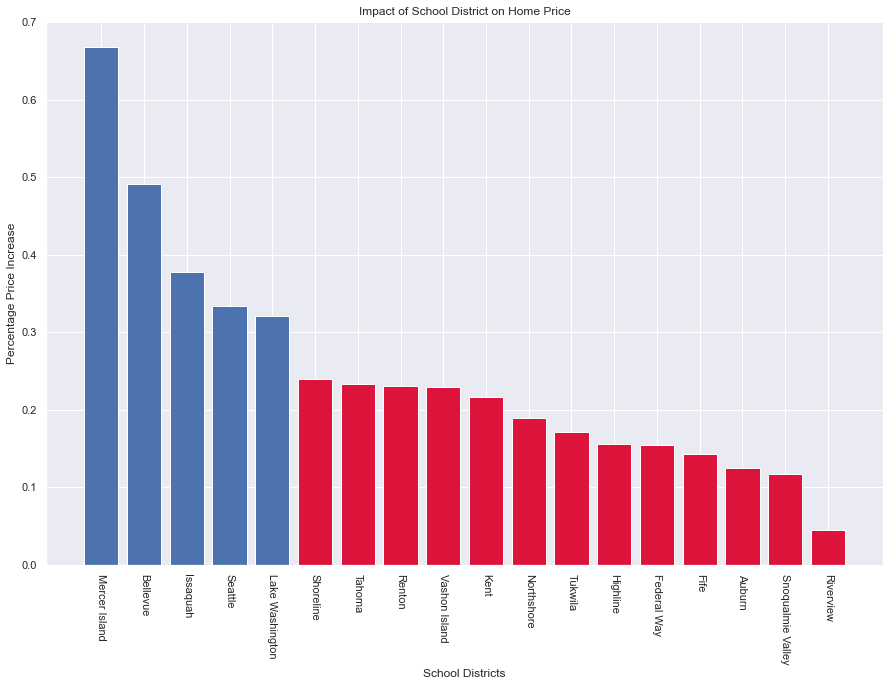

In [59]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.xticks(rotation=-90)
colors = ["b" if dist > 0.25 else "crimson" for dist in dist_coef]
ax.set_title('Impact of School District on Home Price')
ax.set_xlabel('School Districts')
ax.set_ylabel('Percentage Price Increase')
ax.bar(dists, dist_coef, color=colors)
plt.savefig('data/DistrictVsPrice.png', dpi=1000);

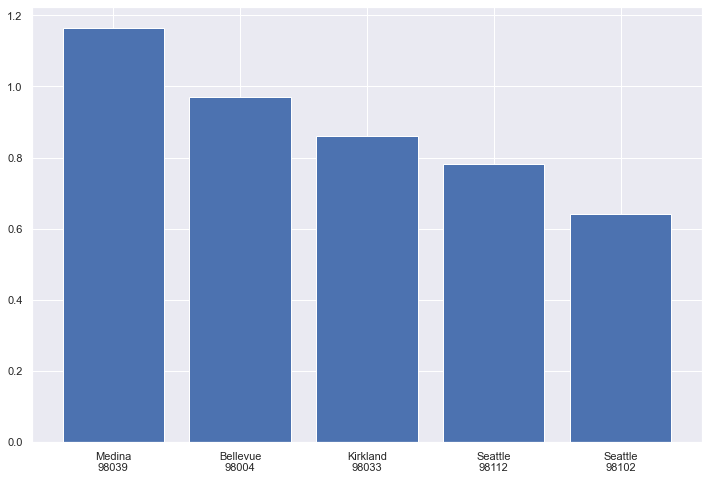

In [60]:
fig, ax = plt.subplots(figsize=(12,8))
height = [1.166, 0.9697, 0.8608, 0.7828, 0.6401]
x = ['Medina\n98039', 'Bellevue\n98004', 'Kirkland\n98033', 'Seattle\n98112', 'Seattle\n98102']
ax.bar(x, height)
plt.savefig('data/ZipValues', dpi=1000);

In [61]:
y_pred = model_scaled.predict(sm.add_constant(X))

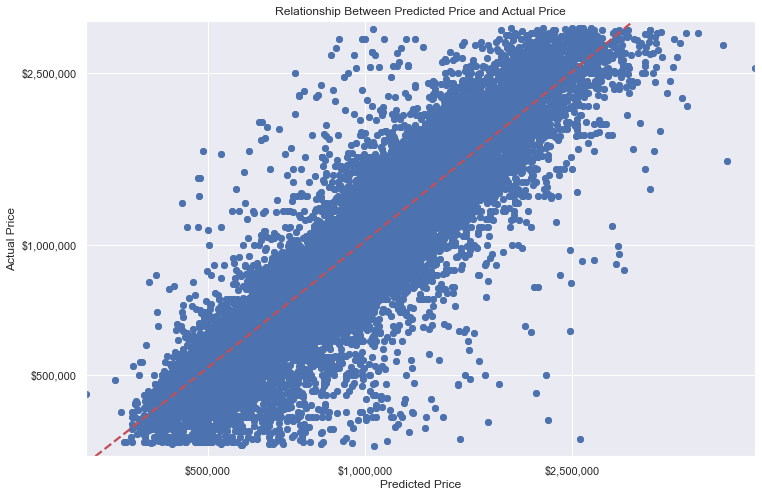

In [62]:
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(x=np.exp(y_pred), y=np.exp(y))
sns.regplot(x=np.exp(y_pred), y=np.exp(y), line_kws={'ls':'--', 'color': 'r'}, ci = None)
plt.yscale('log')
plt.xscale('log')
plt.ylim((325000, 3300000))
ax.set_xticks([500000, 1000000, 2500000])
ax.set_xticklabels(['$500,000', '$1,000,000', '$2,500,000'])
ax.set_yticks([500000, 1000000, 2500000])
ax.set_yticklabels(['$500,000', '$1,000,000', '$2,500,000'])
ax.set_xlabel('Predicted Price')
ax.set_ylabel('Actual Price')
ax.set_title('Relationship Between Predicted Price and Actual Price')
plt.savefig('data/PredictedVsActual.png', dpi=1000);

## Checking assumptions

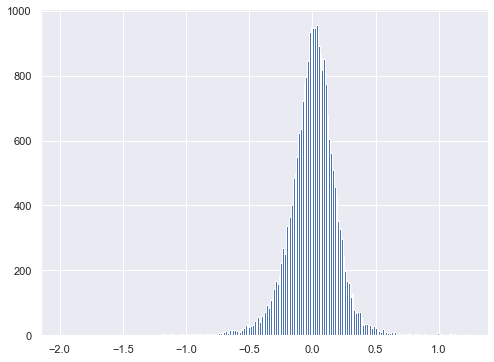

In [63]:
data_resids = y - y_pred
data_resids.hist(bins='auto');

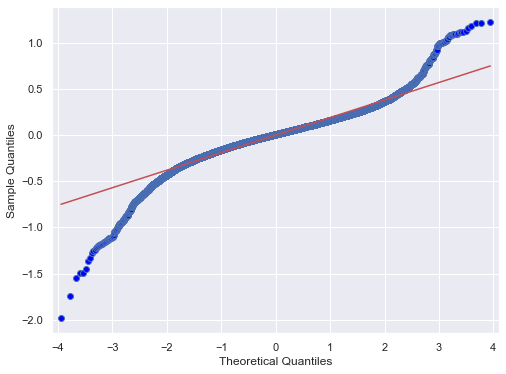

In [64]:
sm.qqplot(data_resids, line='r');

We can see our residuals are normally distributed

## Conclusions

In conclusion, we would make the following recommendations for purchases:

- Average or Above Quality Views
- Good or above Grade of Materials (ideally the higher the better to retain value).
- High SQ Footage of Living Space or Lot Space
- Waterfront Access
- Converting SQ Footage of Basement Space to multiply the value per foot by a factor of 4.
- Modifying Garages with Patio spaces atop to maxmize unused space.
- Avoid neighborhoods with Private Sewer Systems and older buildings.
- Priotizing acquisiton in the following Zip Codes: 98039, 98004, 98033, 98112, 98102, due to the quality of schools.
- Using that access to school's as a selling point to families.